# **Project 4: Real-Time, Sensor-Agnostic Posture Classification on the Arduino Nano 33 BLE Sense Using IMU Windowing, Normalization, and TensorFlow Lite Micro**
 **Author: Anushka Satav**  
 **Course: BMI/CEN 598 — Embedded Machine Learning**  
 **Device: Arduino Nano 33 BLE Sense Rev2**  

# 1. Imports and environment check

In [3]:
# Cell 1 - Imports and environment check
import os
import json
import shutil
from glob import glob

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, classification_report

import tensorflow as tf
from tensorflow.keras import layers, models, callbacks

print("Environment ready. TensorFlow version:", tf.__version__)


Environment ready. TensorFlow version: 2.19.0


#2. Upload Data from IMU

In [4]:
# Cell 2 - Upload CSV files into the Colab session
# Expected filenames:
required_files = [
    "prone.csv", "supine.csv", "side_left.csv", "side_right.csv",
    "sitting_up.csv", "sitting_down.csv", "unknown.csv"
]
print("Please upload the required CSV files via the dialog that appears.")
from google.colab import files
uploaded = files.upload()
print("Uploaded files:", list(uploaded.keys()))
# Verify expected files are present
missing = [f for f in required_files if not os.path.exists(f)]
if missing:
    print("Warning: the following expected files are missing:", missing)
else:
    print("All expected files present.")


Please upload the required CSV files via the dialog that appears.


Saving prone.csv to prone.csv
Saving side_left.csv to side_left.csv
Saving side_right.csv to side_right.csv
Saving sitting_down.csv to sitting_down.csv
Saving sitting_up.csv to sitting_up.csv
Saving supine.csv to supine.csv
Saving unknown.csv to unknown.csv
Uploaded files: ['prone.csv', 'side_left.csv', 'side_right.csv', 'sitting_down.csv', 'sitting_up.csv', 'supine.csv', 'unknown.csv']
All expected files present.


#3. Configuration and Labelling for Data Preparation

In [5]:
# Cell 3 - Configuration (windowing and labels)
SR = 100                       # sampling frequency used when collecting data (Hz)
WINDOW_SEC = 2.0               # window duration in seconds
WINDOW = int(WINDOW_SEC * SR)  # window length in samples (200)
STEP = WINDOW // 2             # 50% overlap (100)

# Files expected (must match uploaded filenames)
file_list = [
    "prone.csv", "supine.csv", "side_left.csv", "side_right.csv",
    "sitting_up.csv", "sitting_down.csv", "unknown.csv"
]

# Merge mapping for left/right and up/down
merge_map = {
    "side_left": "side",
    "side_right": "side",
    "sitting_up": "sitting",
    "sitting_down": "sitting"
}

# Final submission label mapping (1-based for report)
submission_label_order = {
    1: "supine",
    2: "prone",
    3: "side",
    4: "sitting",
    5: "unknown"
}

# Internal (0-based) mapping for training
label_to_index = {v: k-1 for k, v in submission_label_order.items()}  # e.g., 'supine'->0
index_to_label = {v: k for k, v in label_to_index.items()}

print("Window settings: WINDOW =", WINDOW, "STEP =", STEP)
print("Label to index (0-based):", label_to_index)


Window settings: WINDOW = 200 STEP = 100
Label to index (0-based): {'supine': 0, 'prone': 1, 'side': 2, 'sitting': 3, 'unknown': 4}


#4. Cleaning and Merge Data class labels

In [6]:
# Cell 4 - Load CSVs and apply label merging
dfs = []
for fname in file_list:
    if not os.path.exists(fname):
        print("File not found:", fname, "- skipping")
        continue
    df = pd.read_csv(fname, engine='python')
    df.columns = [c.strip() for c in df.columns]
    # Ensure label column exists; if not, infer from filename
    if 'label' not in df.columns:
        base = os.path.basename(fname).lower()
        inferred = None
        for cand in ["prone","supine","side_left","side_right","sitting_up","sitting_down","unknown"]:
            if cand in base:
                inferred = cand
                break
        df['label'] = inferred if inferred else 'unknown'
    # Apply merge map (side_left->side, etc.)
    df['label'] = df['label'].astype(str).map(lambda x: merge_map.get(x, x))
    dfs.append(df)

if len(dfs) == 0:
    raise RuntimeError("No CSV files loaded. Upload files and rerun this cell.")

df_all = pd.concat(dfs, ignore_index=True)
df_all = df_all.dropna().reset_index(drop=True)
print("Total rows loaded:", len(df_all))
print("Label counts:")
print(df_all['label'].value_counts())
print("Sample columns:", df_all.columns.tolist()[:12])


Total rows loaded: 12778
Label counts:
label
unknown    3035
sitting    2442
side       2439
prone      2431
supine     2431
Name: count, dtype: int64
Sample columns: ['timestamp', 'ax', 'ay', 'az', 'gx', 'gy', 'gz', 'mx', 'my', 'mz', 'label']


#5. Detect sensor column names and set sensor groups

In [7]:
# Cell 5 - Automatically detect sensor column names (ax,ay,az / gx,gy,gz / mx,my,mz)
cols = [c.lower() for c in df_all.columns]

# Preferred exact names
def find_cols_by_candidates(candidates):
    found = []
    for c in candidates:
        for col in df_all.columns:
            if col.lower() == c or col.lower().startswith(c):
                found.append(col)
                break
    return found

# Try common prefixes
acc_candidates = ['ax','accx','acc_x','acc']
gyro_candidates = ['gx','gyr','gyro','gy']
mag_candidates = ['mx','mag','magx']

acc_cols = find_cols_by_candidates(['ax','ay','az'])
gyro_cols = find_cols_by_candidates(['gx','gy','gz'])
mag_cols = find_cols_by_candidates(['mx','my','mz'])

# If not detected, fallback to positional numeric columns
if not (len(acc_cols) == 3 and len(gyro_cols) == 3 and len(mag_cols) == 3):
    numeric_cols = df_all.select_dtypes(include=[np.number]).columns.tolist()
    numeric_cols = [c for c in numeric_cols if 'time' not in c.lower()]
    if len(numeric_cols) >= 9:
        acc_cols = numeric_cols[0:3]
        gyro_cols = numeric_cols[3:6]
        mag_cols = numeric_cols[6:9]
    else:
        # Final explicit fallback: expected standard names
        if all(x in df_all.columns for x in ['ax','ay','az','gx','gy','gz','mx','my','mz']):
            acc_cols = ['ax','ay','az']
            gyro_cols = ['gx','gy','gz']
            mag_cols = ['mx','my','mz']
        else:
            raise RuntimeError("Could not detect sensor columns. Check CSV headers.")

print("Detected columns:")
print("Accelerometer:", acc_cols)
print("Gyroscope:", gyro_cols)
print("Magnetometer:", mag_cols)


Detected columns:
Accelerometer: ['ax', 'ay', 'az']
Gyroscope: ['gx', 'gy', 'gz']
Magnetometer: ['mx', 'my', 'mz']


#6. Sliding Windows (Dataset with all 3 Sensor Types)

In [10]:
# Cell 6 - Create sliding windows for each contiguous labeled segment and for each sensor type.
def windows_from_segment(segment_df, cols, window=WINDOW, step=STEP):
    arr = segment_df[cols].values.astype(np.float32)
    n = arr.shape[0]
    out = []
    for start in range(0, n - window + 1, step):
        out.append(arr[start:start+window])
    return out

X_list = []
Y_list = []
sensor_list = []  # 'acc', 'gyr', 'mag'

N = len(df_all)
i = 0
while i < N:
    j = i
    lab = df_all['label'].iloc[i]
    while j < N and df_all['label'].iloc[j] == lab:
        j += 1
    segment = df_all.iloc[i:j]
    if segment.shape[0] >= WINDOW:
        # windows from accelerometer
        wins_acc = windows_from_segment(segment, acc_cols, window=WINDOW, step=STEP)
        for w in wins_acc:
            X_list.append(w)
            Y_list.append(label_to_index.get(lab, label_to_index['unknown']))
            sensor_list.append('acc')
        # windows from gyroscope
        wins_gyr = windows_from_segment(segment, gyro_cols, window=WINDOW, step=STEP)
        for w in wins_gyr:
            X_list.append(w)
            Y_list.append(label_to_index.get(lab, label_to_index['unknown']))
            sensor_list.append('gyr')
        # windows from magnetometer
        wins_mag = windows_from_segment(segment, mag_cols, window=WINDOW, step=STEP)
        for w in wins_mag:
            X_list.append(w)
            Y_list.append(label_to_index.get(lab, label_to_index['unknown']))
            sensor_list.append('mag')
    i = j

X = np.array(X_list, dtype=np.float32)
Y = np.array(Y_list, dtype=np.int32)
sensor_types = np.array(sensor_list)
print("Total windows:", X.shape)
(unique_labels, counts) = np.unique(Y, return_counts=True)
print("Label distribution (0-based index -> count):", dict(zip(unique_labels, counts)))
print("Sensor distribution:", dict(zip(*np.unique(sensor_types, return_counts=True))))


Total windows: (363, 200, 3)
Label distribution (0-based index -> count): {np.int32(0): np.int64(69), np.int32(1): np.int64(69), np.int32(2): np.int64(69), np.int32(3): np.int64(69), np.int32(4): np.int64(87)}
Sensor distribution: {np.str_('acc'): np.int64(121), np.str_('gyr'): np.int64(121), np.str_('mag'): np.int64(121)}


#7. Split the Dataset - Train/Validation/Test

In [11]:
# Cell 7 - Shuffle and split. We stratify by label only; sensor types will be distributed automatically.
X, Y, sensor_types = shuffle(X, Y, sensor_types, random_state=42)

X_train, X_temp, y_train, y_temp, sensor_train, sensor_temp = train_test_split(
    X, Y, sensor_types, test_size=0.30, stratify=Y, random_state=42)

X_val, X_test, y_val, y_test, sensor_val, sensor_test = train_test_split(
    X_temp, y_temp, sensor_temp, test_size=0.50, stratify=y_temp, random_state=42)

print("Shapes: Train", X_train.shape, "Val", X_val.shape, "Test", X_test.shape)
print("Sensor composition in train:", dict(zip(*np.unique(sensor_train, return_counts=True))))


Shapes: Train (254, 200, 3) Val (54, 200, 3) Test (55, 200, 3)
Sensor composition in train: {np.str_('acc'): np.int64(85), np.str_('gyr'): np.int64(82), np.str_('mag'): np.int64(87)}


#8. Normalization of Data (Mean/Std)
Save scalar values (mean/std of all three sensor data)

In [12]:
# Cell 8 - Per-sensor StandardScaler fit on training windows only

# Prepare containers
scaler_acc = StandardScaler()
scaler_gyr = StandardScaler()
scaler_mag = StandardScaler()

# Function to gather per-sensor training data in shape (-1, 3)
def gather_per_sensor(X_set, sensor_set, sensor_name):
    mask = sensor_set == sensor_name
    if np.sum(mask) == 0:
        return np.empty((0,3),dtype=np.float32)
    # shape (num_windows, WINDOW, 3) -> reshape to (-1,3)
    arr = X_set[mask].reshape(-1, 3)
    return arr

acc_train_vals = gather_per_sensor(X_train, sensor_train, 'acc')
gyr_train_vals = gather_per_sensor(X_train, sensor_train, 'gyr')
mag_train_vals = gather_per_sensor(X_train, sensor_train, 'mag')

if acc_train_vals.shape[0] == 0 or gyr_train_vals.shape[0] == 0 or mag_train_vals.shape[0] == 0:
    raise RuntimeError("One of the sensor training sets is empty. Check data collection and windowing.")

scaler_acc.fit(acc_train_vals)
scaler_gyr.fit(gyr_train_vals)
scaler_mag.fit(mag_train_vals)

# Save scalers to disk (.pkl)
import pickle
os.makedirs("artifacts", exist_ok=True)
with open("artifacts/scaler_acc.pkl", "wb") as f:
    pickle.dump(scaler_acc, f)
with open("artifacts/scaler_gyr.pkl", "wb") as f:
    pickle.dump(scaler_gyr, f)
with open("artifacts/scaler_mag.pkl", "wb") as f:
    pickle.dump(scaler_mag, f)

# Save scalers as human-readable JSON for Arduino
scaler_json = {
    "acc_mean": scaler_acc.mean_.tolist(),
    "acc_std":  scaler_acc.scale_.tolist(),
    "gyr_mean": scaler_gyr.mean_.tolist(),
    "gyr_std":  scaler_gyr.scale_.tolist(),
    "mag_mean": scaler_mag.mean_.tolist(),
    "mag_std":  scaler_mag.scale_.tolist(),
    "sr": SR,
    "window": WINDOW
}
with open("artifacts/scaler.json","w") as f:
    json.dump(scaler_json, f, indent=2)

print("Saved per-sensor scalers to artifacts/scaler_acc.pkl, scaler_gyr.pkl, scaler_mag.pkl and artifacts/scaler.json")
print("Accelerometer mean/std:", scaler_acc.mean_.tolist(), scaler_acc.scale_.tolist())
print("Gyroscope mean/std:", scaler_gyr.mean_.tolist(), scaler_gyr.scale_.tolist())
print("Magnetometer mean/std:", scaler_mag.mean_.tolist(), scaler_mag.scale_.tolist())


Saved per-sensor scalers to artifacts/scaler_acc.pkl, scaler_gyr.pkl, scaler_mag.pkl and artifacts/scaler.json
Accelerometer mean/std: [0.11407882117228035, -0.05025352850545417, 0.06799059004917303] [0.5231154091805787, 0.4739286529227871, 0.694604436378731]
Gyroscope mean/std: [-0.6545908586060765, 0.29120000352787717, -0.2711201219858102] [21.05253540931651, 11.27825384580398, 8.501902393856472]
Magnetometer mean/std: [-24.656206896551723, 12.822931034482759, 30.95109195402299] [28.92012327843568, 24.769151942702795, 36.37391178547843]


#9. Normalize Dataset

In [13]:
# Cell 9 - Normalize each sample according to its sensor type
def normalize_set(X_set, sensor_set, scalers):
    X_out = np.empty_like(X_set)
    for idx, s in enumerate(sensor_set):
        if s == 'acc':
            X_out[idx] = scalers['acc'].transform(X_set[idx].reshape(-1,3)).reshape(X_set[idx].shape)
        elif s == 'gyr':
            X_out[idx] = scalers['gyr'].transform(X_set[idx].reshape(-1,3)).reshape(X_set[idx].shape)
        elif s == 'mag':
            X_out[idx] = scalers['mag'].transform(X_set[idx].reshape(-1,3)).reshape(X_set[idx].shape)
        else:
            # fallback: no scaling
            X_out[idx] = X_set[idx]
    return X_out

scalers = {'acc': scaler_acc, 'gyr': scaler_gyr, 'mag': scaler_mag}

X_train_n = normalize_set(X_train, sensor_train, scalers)
X_val_n = normalize_set(X_val, sensor_val, scalers)
X_test_n = normalize_set(X_test, sensor_test, scalers)

print("Normalization applied. Sample shapes:", X_train_n.shape, X_val_n.shape, X_test_n.shape)


Normalization applied. Sample shapes: (254, 200, 3) (54, 200, 3) (55, 200, 3)


#10. Define Model: 1D-CNN and Dense NN

In [14]:
# Cell 10 - Model definitions (Dense and 1D-CNN)
num_classes = len(label_to_index)
input_shape = (WINDOW, 3)

def build_dense():
    model = models.Sequential([
        layers.Input(shape=input_shape),
        layers.Flatten(),
        layers.Dense(256, activation='relu'),
        layers.Dropout(0.3),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.2),
        layers.Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

def build_cnn():
    model = models.Sequential([
        layers.Input(shape=input_shape),
        layers.Conv1D(32, 5, activation='relu', padding='same'),
        layers.MaxPool1D(2),
        layers.Conv1D(64, 5, activation='relu', padding='same'),
        layers.MaxPool1D(2),
        layers.Conv1D(128, 3, activation='relu', padding='same'),
        layers.GlobalAveragePooling1D(),
        layers.Dropout(0.3),
        layers.Dense(64, activation='relu'),
        layers.Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

dense_model = build_dense()
cnn_model = build_cnn()
dense_model.summary()
cnn_model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten (Flatten)               │ (None, 600)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       153,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 187,397 (732.02 KB)

 Trainable params: 187,397 (732.02 KB)

 Non-trainable params: 0 (0.00 B)

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 200, 32)        │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 100, 32)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 100, 64)        │        10,304 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 50, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 50, 128)        │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d        │ (None, 128)            │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 5)              │           325 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 44,101 (172.27 KB)

 Trainable params: 44,101 (172.27 KB)

 Non-trainable params: 0 (0.00 B)

#11. Train Both Models

In [15]:
# Cell 11 - Training
EPOCHS = 100
BATCH = 64
es = callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=1)

history_dense = dense_model.fit(
    X_train_n, y_train,
    validation_data=(X_val_n, y_val),
    epochs=EPOCHS, batch_size=BATCH,
    callbacks=[es], verbose=2
)

history_cnn = cnn_model.fit(
    X_train_n, y_train,
    validation_data=(X_val_n, y_val),
    epochs=EPOCHS, batch_size=BATCH,
    callbacks=[es], verbose=2
)

# Save history objects
import pickle
with open("artifacts/history_dense.pkl","wb") as f:
    pickle.dump(history_dense.history, f)
with open("artifacts/history_cnn.pkl","wb") as f:
    pickle.dump(history_cnn.history, f)
print("Training complete and histories saved.")


Epoch 1/100
4/4 - 5s - 1s/step - accuracy: 0.3622 - loss: 1.6009 - val_accuracy: 0.5556 - val_loss: 0.8919
Epoch 2/100
4/4 - 0s - 22ms/step - accuracy: 0.5433 - loss: 0.9054 - val_accuracy: 0.6481 - val_loss: 0.7412
Epoch 3/100
4/4 - 0s - 20ms/step - accuracy: 0.5906 - loss: 0.7752 - val_accuracy: 0.6296 - val_loss: 0.7351
Epoch 4/100
4/4 - 0s - 20ms/step - accuracy: 0.6693 - loss: 0.6603 - val_accuracy: 0.6852 - val_loss: 0.7122
Epoch 5/100
4/4 - 0s - 21ms/step - accuracy: 0.6693 - loss: 0.6510 - val_accuracy: 0.7222 - val_loss: 0.6771
Epoch 6/100
4/4 - 0s - 23ms/step - accuracy: 0.7205 - loss: 0.6283 - val_accuracy: 0.7407 - val_loss: 0.6525
Epoch 7/100
4/4 - 0s - 19ms/step - accuracy: 0.7717 - loss: 0.5647 - val_accuracy: 0.6667 - val_loss: 0.6847
Epoch 8/100
4/4 - 0s - 19ms/step - accuracy: 0.7874 - loss: 0.5442 - val_accuracy: 0.7222 - val_loss: 0.6670
Epoch 9/100
4/4 - 0s - 18ms/step - accuracy: 0.7953 - loss: 0.5097 - val_accuracy: 0.7037 - val_loss: 0.6616
Epoch 10/100
4/4 - 0s

#12. Plot training vs validation accuracy & loss

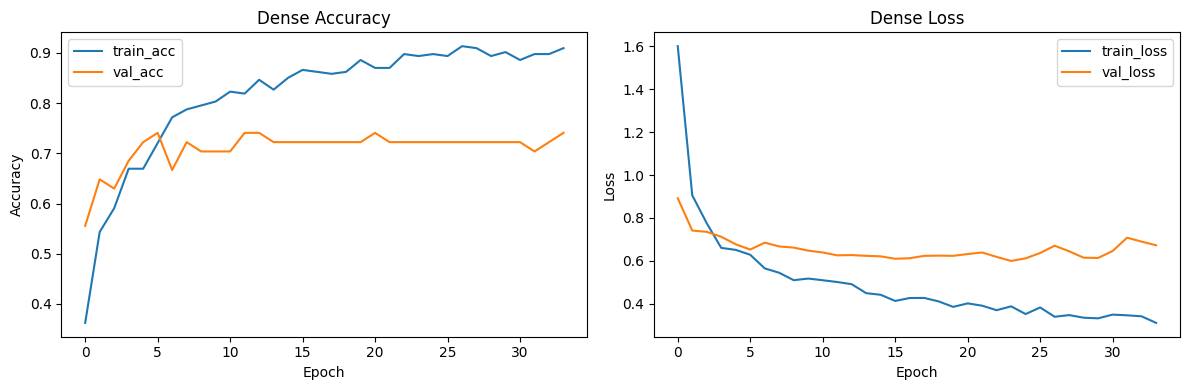

Saved: artifacts/Dense_training_curves.png


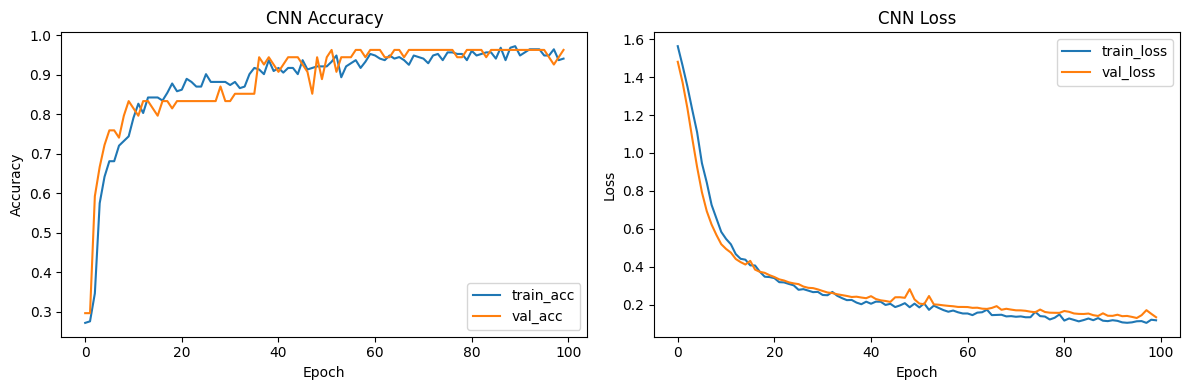

Saved: artifacts/CNN_training_curves.png


In [16]:
# Cell 12 - Plot training curves and save
def plot_history(h, name):
    plt.figure(figsize=(12,4))
    plt.subplot(1,2,1)
    plt.plot(h['accuracy'], label='train_acc')
    plt.plot(h['val_accuracy'], label='val_acc')
    plt.title(f"{name} Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.subplot(1,2,2)
    plt.plot(h['loss'], label='train_loss')
    plt.plot(h['val_loss'], label='val_loss')
    plt.title(f"{name} Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.tight_layout()
    out = f"artifacts/{name}_training_curves.png"
    plt.savefig(out)
    plt.show()
    print("Saved:", out)

plot_history(history_dense.history, "Dense")
plot_history(history_cnn.history, "CNN")


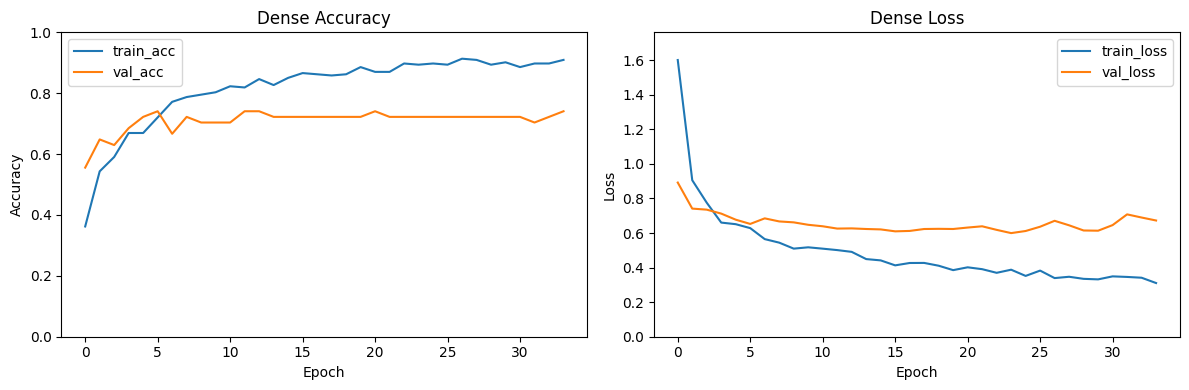

Saved: artifacts/Dense_training_curves.png


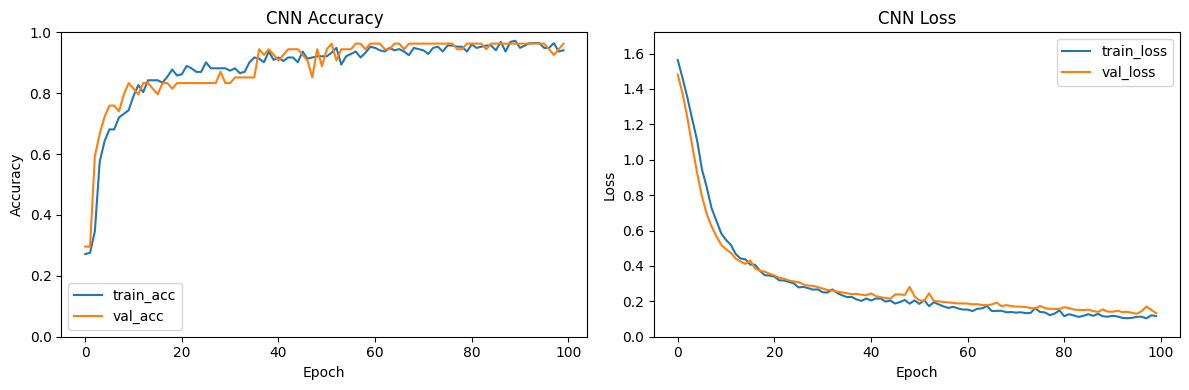

Saved: artifacts/CNN_training_curves.png


In [17]:
import matplotlib.pyplot as plt

def plot_history(h, name):
    plt.figure(figsize=(12,4))

    # Accuracy plot
    plt.subplot(1,2,1)
    plt.plot(h['accuracy'], label='train_acc')
    plt.plot(h['val_accuracy'], label='val_acc')
    plt.title(f"{name} Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.ylim(0, 1)  # Full accuracy range
    plt.legend()

    # Loss plot
    plt.subplot(1,2,2)
    plt.plot(h['loss'], label='train_loss')
    plt.plot(h['val_loss'], label='val_loss')
    plt.title(f"{name} Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    # Optional: set full range from 0 to max loss
    max_loss = max(max(h['loss']), max(h['val_loss']))
    plt.ylim(0, max_loss * 1.1)  # slightly higher than max for clarity
    plt.legend()

    plt.tight_layout()
    out = f"artifacts/{name}_training_curves.png"
    plt.savefig(out)
    plt.show()
    print("Saved:", out)

# Example usage
plot_history(history_dense.history, "Dense")
plot_history(history_cnn.history, "CNN")


#13. Evaluate on test set and save confusion matrices

Dense - Test loss: 0.9316, Test accuracy: 0.7273
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step
Classification report:
              precision    recall  f1-score   support

      supine     0.7143    1.0000    0.8333        10
       prone     1.0000    0.7000    0.8235        10
        side     0.6923    0.8182    0.7500        11
     sitting     0.8333    0.4545    0.5882        11
     unknown     0.6000    0.6923    0.6429        13

    accuracy                         0.7273        55
   macro avg     0.7680    0.7330    0.7276        55
weighted avg     0.7586    0.7273    0.7208        55



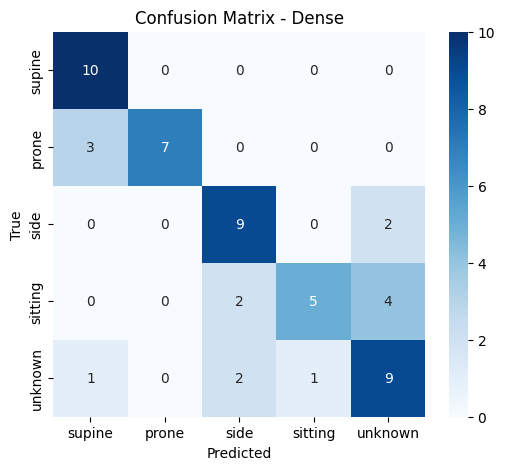

CNN - Test loss: 0.4637, Test accuracy: 0.9273
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 317ms/step
Classification report:
              precision    recall  f1-score   support

      supine     0.9091    1.0000    0.9524        10
       prone     1.0000    0.9000    0.9474        10
        side     0.9000    0.8182    0.8571        11
     sitting     1.0000    1.0000    1.0000        11
     unknown     0.8571    0.9231    0.8889        13

    accuracy                         0.9273        55
   macro avg     0.9332    0.9283    0.9292        55
weighted avg     0.9297    0.9273    0.9269        55



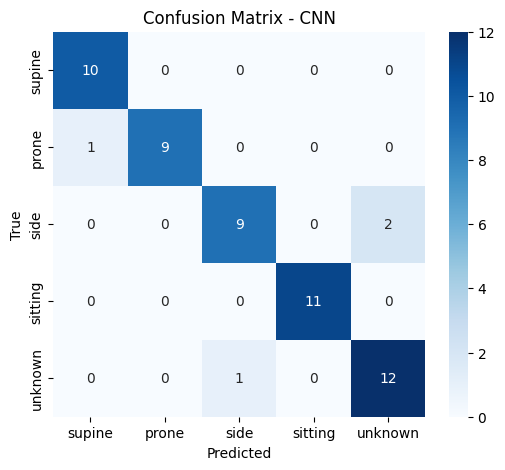

In [18]:
# Cell 13 - Evaluation and confusion matrices
def evaluate_and_report(model, X_test, y_test, name):
    loss, acc = model.evaluate(X_test, y_test, verbose=0)
    print(f"{name} - Test loss: {loss:.4f}, Test accuracy: {acc:.4f}")
    preds = model.predict(X_test).argmax(axis=1)
    print("Classification report:")
    print(classification_report(y_test, preds, target_names=[index_to_label[i] for i in range(num_classes)], digits=4))
    cm = confusion_matrix(y_test, preds)
    plt.figure(figsize=(6,5))
    sns.heatmap(cm, annot=True, fmt='d', xticklabels=[index_to_label[i] for i in range(num_classes)],
                yticklabels=[index_to_label[i] for i in range(num_classes)], cmap='Blues')
    plt.title(f"Confusion Matrix - {name}")
    plt.ylabel("True")
    plt.xlabel("Predicted")
    out = f"artifacts/cm_{name}.png"
    plt.savefig(out)
    plt.show()
    return acc

acc_dense = evaluate_and_report(dense_model, X_test_n, y_test, "Dense")
acc_cnn = evaluate_and_report(cnn_model, X_test_n, y_test, "CNN")


#14. Choose best model and save Keras model

In [19]:
# Cell 14 - Select best model and save
if acc_cnn >= acc_dense:
    best_model = cnn_model
    best_name = "cnn"
else:
    best_model = dense_model
    best_name = "dense"

os.makedirs("models", exist_ok=True)
best_model.save(f"models/best_{best_name}.h5")
print("Saved best Keras model:", f"models/best_{best_name}.h5")


Saved best Keras model: models/best_cnn.h5


#15. Convert best Keras model to TFLite (float) and INT8 quantized

In [20]:
# Cell 15 - Convert Keras model to TFLite (float and INT8 if possible)
keras_path = f"models/best_{best_name}.h5"
tflite_path = f"models/best_{best_name}.tflite"

converter = tf.lite.TFLiteConverter.from_keras_model(best_model)
tflite_model = converter.convert()
open(tflite_path, "wb").write(tflite_model)
print("Saved float TFLite:", tflite_path)

# INT8 quantization with representative dataset (uses normalized samples)
def representative_dataset_gen():
    n = min(100, X_train_n.shape[0])
    for i in range(n):
        sample = X_train_n[i:i+1].astype(np.float32)
        yield [sample]

converter = tf.lite.TFLiteConverter.from_keras_model(best_model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.representative_dataset = representative_dataset_gen
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
converter.inference_input_type = tf.int8
converter.inference_output_type = tf.int8

try:
    tflite_q = converter.convert()
    qpath = f"models/best_{best_name}_int8.tflite"
    open(qpath, "wb").write(tflite_q)
    print("Saved INT8 quantized TFLite:", qpath)
except Exception as e:
    print("INT8 conversion failed:", e)


Saved artifact at '/tmp/tmpo_3h57vu'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 200, 3), dtype=tf.float32, name='keras_tensor_7')
Output Type:
  TensorSpec(shape=(None, 5), dtype=tf.float32, name=None)
Captures:
  133175180755792: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133175180759056: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133175180758672: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133175180760400: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133175180761360: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133175180760592: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133175180761744: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133175180761552: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133175180762128: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133175180761936: TensorSpec(shape=(), dtype=tf.resource, name=None)
Saved float TFLite:

/usr/local/lib/python3.12/dist-packages/tensorflow/lite/python/convert.py:854: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn(


#16. Convert .tflite to C source (Python routine) and save header

In [21]:
# Cell 16 - Convert TFLite to C array for Arduino inclusion
def tflite_to_c(tflite_file, out_cc, out_h, array_name="g_model_data"):
    data = open(tflite_file, "rb").read()
    n = len(data)
    with open(out_cc, "w") as f:
        f.write('#include "{}"\n\n'.format(out_h))
        f.write(f'const unsigned int {array_name}_len = {n};\n')
        f.write(f'const unsigned char {array_name}[] = {{\n')
        for i, b in enumerate(data):
            if i % 12 == 0:
                f.write("  ")
            f.write(str(b))
            if i != n-1:
                f.write(",")
            if i % 12 == 11:
                f.write("\n")
        f.write("\n};\n")
    with open(out_h, "w") as f:
        f.write('#pragma once\n\n')
        f.write(f'extern const unsigned int {array_name}_len;\n')
        f.write(f'extern const unsigned char {array_name}[];\n')
    print("Wrote", out_cc, "and", out_h)

# choose quantized if available otherwise float
chosen_tflite = f"models/best_{best_name}_int8.tflite" if os.path.exists(f"models/best_{best_name}_int8.tflite") else f"models/best_{best_name}.tflite"
os.makedirs("artifacts", exist_ok=True)
tflite_to_c(chosen_tflite, "artifacts/model_data.cc", "artifacts/model_data.h")
print("Created artifacts/model_data.cc and artifacts/model_data.h from", chosen_tflite)


Wrote artifacts/model_data.cc and artifacts/model_data.h
Created artifacts/model_data.cc and artifacts/model_data.h from models/best_cnn_int8.tflite


#17. Create test-accuracy comparison bar and package everything into zip

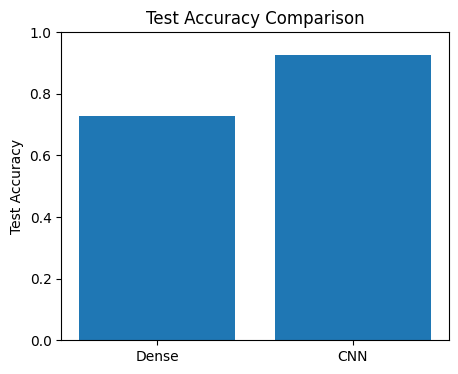

Created submission_artifacts_all.zip in the working directory.


In [22]:
# Cell 17 - Test accuracy comparison and package artifacts for submission
plt.figure(figsize=(5,4))
plt.bar(['Dense','CNN'], [acc_dense, acc_cnn])
plt.ylim(0,1)
plt.ylabel("Test Accuracy")
plt.title("Test Accuracy Comparison")
plt.savefig("artifacts/test_accuracy_comparison.png")
plt.show()

# Copy models to artifacts folder
shutil.copy(f"models/best_{best_name}.h5", "artifacts")
shutil.copy(chosen_tflite, "artifacts")
if os.path.exists(f"models/best_{best_name}_int8.tflite"):
    shutil.copy(f"models/best_{best_name}_int8.tflite", "artifacts")

# Make final submission zip
shutil.make_archive("submission_artifacts_all", 'zip', root_dir="artifacts")
print("Created submission_artifacts_all.zip in the working directory.")


#18. Download helper

In [23]:
# Cell 18 - Download submission zip
from google.colab import files
files.download("submission_artifacts_all.zip")
print("Download initiated for submission_artifacts_all.zip")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Download initiated for submission_artifacts_all.zip
